# Estimators for categorical variables

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Plot helper functions
from plot_helpers import plot_pdf
from plot_helpers import savefigure

In [3]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn't work
from plot_helpers import RCPARAMS
RCPARAMS.update({'figure.figsize': (10, 3)})   # good for screen
# RCPARAMS.update({'figure.figsize': (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# Useful colors
snspal = sns.color_palette()
blue, orange, purple = snspal[0], snspal[1], snspal[4]

# High-resolution please
%config InlineBackend.figure_format = 'retina'

# Where to store figures
DESTDIR = "figures/stats/confidence_intervals"

<Figure size 640x480 with 0 Axes>

In [4]:
# set random seed for repeatability
np.random.seed(42)

In [5]:
#######################################################

$\def\stderr#1{\mathbf{se}_{#1}}$
$\def\stderrhat#1{\hat{\mathbf{se}}_{#1}}$
$\newcommand{\Mean}{\textbf{Mean}}$
$\newcommand{\Var}{\textbf{Var}}$
$\newcommand{\Std}{\textbf{Std}}$
$\newcommand{\Freq}{\textbf{Freq}}$
$\newcommand{\RelFreq}{\textbf{RelFreq}}$
$\newcommand{\DMeans}{\textbf{DMeans}}$
$\newcommand{\Prop}{\textbf{Prop}}$
$\newcommand{\DProps}{\textbf{DProps}}$

$$
\newcommand{\CI}[1]{\textbf{CI}_{#1}}
\newcommand{\CIL}[1]{\textbf{L}_{#1}}
\newcommand{\CIU}[1]{\textbf{U}_{#1}}
\newcommand{\ci}[1]{\textbf{ci}_{#1}}
\newcommand{\cil}[1]{\textbf{l}_{#1}}
\newcommand{\ciu}[1]{\textbf{u}_{#1}}
$$


(this cell contains the macro definitions like $\stderr{\overline{\mathbf{x}}}$, $\stderrhat{}$, $\Mean$, ...)

# Estimators for categorical variables

We'll also discuss estimators for working with samples of discrete values, based on counting:

#### Sample proportion
  - estimator: $\widehat{p} = \RelFreq_{\mathbf{x}}(1) = \frac{ \textrm{count of } 1\textrm{s in } \mathbf{x} }{n}$
  - gives an estimate of the parameter $p$ for a Bernoulli population

In [6]:
def prop(sample):
    """
    Compute the proportion of success (1) outcomes in `sample`.
    """
    counts = sample.value_counts()
    count_ones = counts[1]
    phat = count_ones / len(sample)
    return phat

#### Difference between sample proportions
  - estimator: $\hat{d} = \DProps(\mathbf{x}, \mathbf{y}) = \widehat{p}_{\mathbf{x}} - \widehat{p}_{\mathbf{y}}$
  - gives an estimate for the difference between population proportions $\delta = p_x - p_y$

In [7]:
def dprops(xsample, ysample):
    """
    Compute the difference between sample propotions.
    """
    phatx = prop(xsample)
    phaty = prop(ysample)
    dhat = phatx - phaty
    return dhat

#### Example 2: A/B website proportions and difference between proportions

In [8]:
visitors = pd.read_csv("../datasets/visitors.csv")
xA = visitors[visitors["version"]=="A"]["bought"]
xB = visitors[visitors["version"]=="B"]["bought"]

In [9]:
prop(xA)

0.06482465462274177

In [10]:
# # ALT.
# mean(xA)

In [11]:
# # ALT.
# np.count_nonzero(xA) / len(xA)

In [12]:
prop(xB)

0.03777148253068933

In [13]:
dhat = dprops(xA, xB)
dhat

0.027053172092052442

### Examples of sampling distributions

Let's look at the same estimators that we described in the previous section,
but this time applied to *random* samples of size $n$:

- Sample proportion: $\widehat{P} = g(\mathbf{X}) = \frac{1}{n}\sum_{i=1}^n X_i$
- Difference between proportions: $\hat{D} = \widehat{P}_{\mathbf{X}} - \widehat{P}_{\mathbf{Y}} = d(\mathbf{X}, \mathbf{Y})$


### Proportion estimator


In [14]:
visitors = pd.read_csv("../datasets/visitors.csv")
xA = visitors[visitors["version"]=="A"]["bought"].values
phat = xA.mean()
phat

0.06482465462274177

In [15]:
pvar = phat*(1-phat)
pvar

0.06062241877578401

In [16]:
n = len(xA)
se_Phat = np.sqrt(pvar/n)
se_Phat

0.008026418836358226

Normal approximation to the sampling distribution.

<Axes: xlabel='x', ylabel='$f_{X}$'>

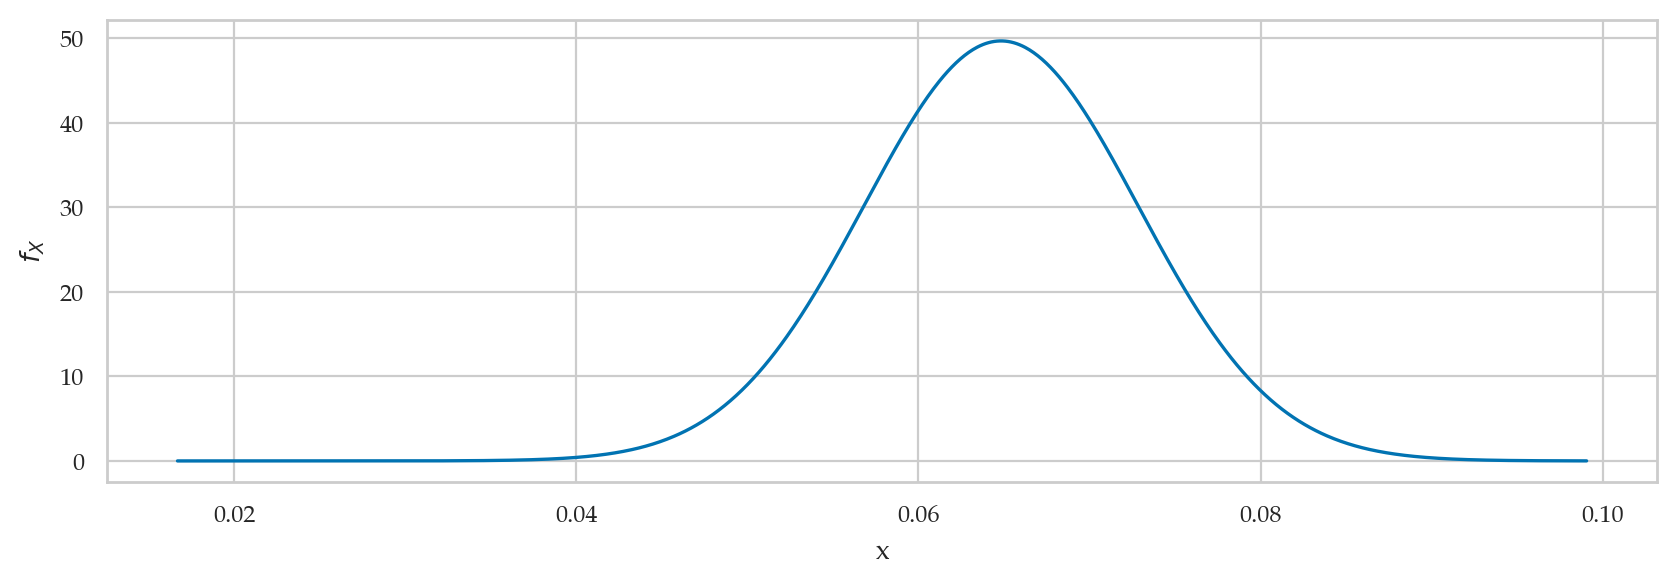

In [17]:
from scipy.stats import norm
Phat = norm(phat, se_Phat)
plot_pdf(Phat)

### Difference between proportion estimator

In [18]:
visitors = pd.read_csv("../datasets/visitors.csv")
xA = visitors[visitors["version"]=="A"]["bought"].values
xB = visitors[visitors["version"]=="B"]["bought"].values
pAhat = xA.mean()
pBhat = xB.mean()
pAhat, pBhat

(0.06482465462274177, 0.03777148253068933)

In [19]:
d = pAhat - pBhat
d

0.027053172092052442

In [20]:
nA, nB = len(xA), len(xB)
varA = pAhat*(1-pAhat)
varB = pBhat*(1-pBhat)
seD = np.sqrt(varA/nA + varB/nB)

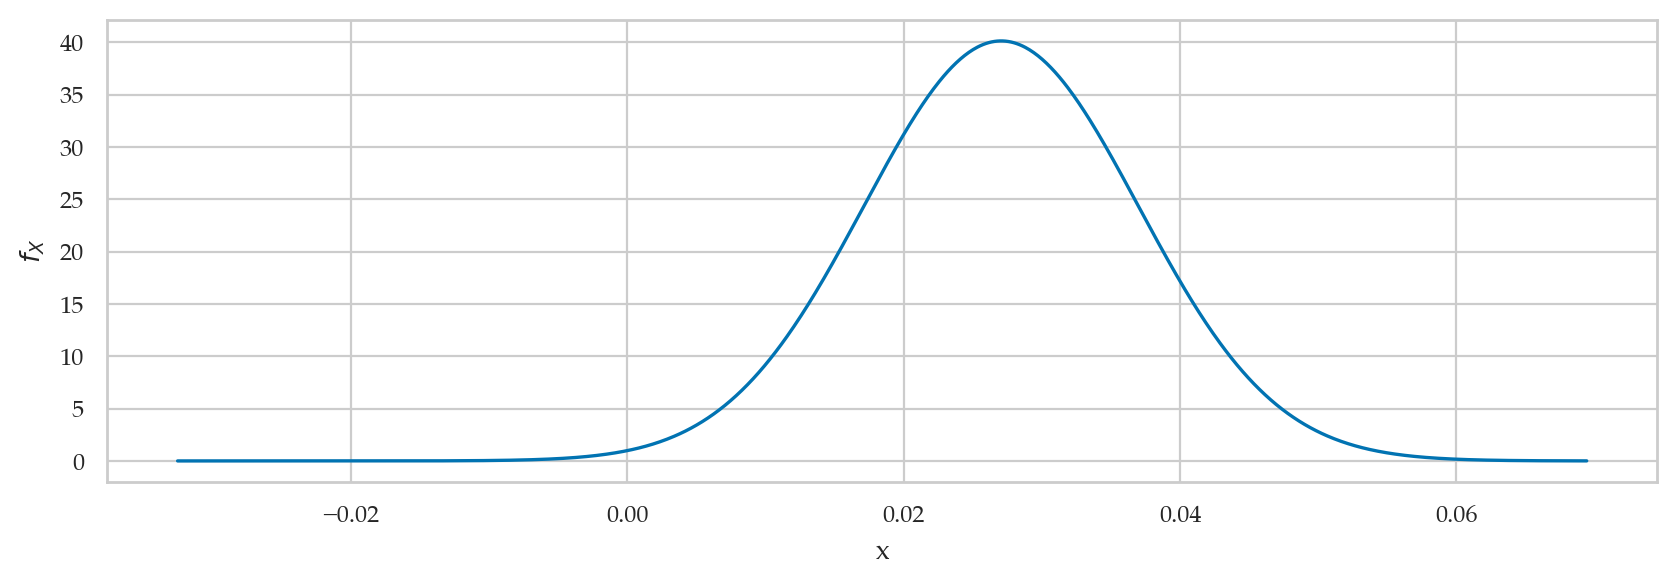

In [21]:
from scipy.stats import norm
Dhat = norm(d, seD)
ax = plot_pdf(Dhat)

## Testing for a difference between proportions

In [22]:
visitors = pd.read_csv("../datasets/visitors.csv")
# visitors

In [23]:
visitors.groupby("version")["bought"].describe()

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
A,941.0,0.064825,0.246347,0.0,0.0,0.0,0.0,1.0
B,1059.0,0.037771,0.190733,0.0,0.0,0.0,0.0,1.0


In [24]:
def prop(sample):
    """
    Compute the proportion of success (1) outcomes in `sample`.
    """
    counts = sample.value_counts()
    count_ones = counts[1]
    phat = count_ones / len(sample)
    return phat

def dprops(xsample, ysample):
    """
    Compute the difference between sample propotions.
    """
    phatx = prop(xsample)
    phaty = prop(ysample)
    dhat = phatx - phaty
    return dhat


In [25]:
# observed difference between means
xA = visitors[visitors["version"]=="A"]["bought"]
xB = visitors[visitors["version"]=="B"]["bought"]
dprops(xA, xB)

0.027053172092052442

In [26]:
def resample_under_H0(sample, groupcol="group"):
    """
    Return a copy of the dataframe `sample` with the labels in the column `groupcol`
    modified based on a random permutation of the values in the original sample.
    """
    resample = sample.copy()
    labels = sample[groupcol].values
    newlabels = np.random.permutation(labels)
    resample[groupcol] = newlabels
    return resample
# resample_under_H0(visitors, groupcol="version")

In [27]:
# permute the `version` labels
visitors_perm = resample_under_H0(visitors, groupcol="version")

# extract price permuted samples 
xA = visitors_perm[visitors_perm["version"]=="A"]["bought"]
xB = visitors_perm[visitors_perm["version"]=="B"]["bought"]

# compute the difference in proportions for the permuted labels
dprops(xA, xB)

-0.021114499573013666

In [28]:
def gen_sampling_dist_under_H02(data, permutations=10000):
    """
    Obtain the sampling distribution of `dprops` under H0
    by repeatedly permutations of the group labels.
    """
    pstats = []
    for i in range(0, permutations):
        data_perm = resample_under_H0(data, groupcol="version")
        xA_perm = data_perm[data_perm["version"]=="A"]["bought"]
        xB_perm = data_perm[data_perm["version"]=="B"]["bought"]
        dhat_perm = dprops(xA_perm, xB_perm)
        pstats.append(dhat_perm)
    return pstats


In [29]:
def permutation_test2(data):
    """
    Compute the p-value of the observed `dprops(xB,xA)` under H0.
    """
    # Obtain the sampling distribution of `dmeans` under H0
    pstats = gen_sampling_dist_under_H02(data)

    # Compute the value of `dmeans` for the observed data
    xA = data[data["version"]=="A"]["bought"]
    xB = data[data["version"]=="B"]["bought"]
    dhat = dprops(xB, xA)

    # Compute p-value of `dhat` under the distribution `pstats` 
    # (how many of `pstats` are equal-or-more-extreme than `dhat`)
    tailstats = [pstat for pstat in pstats \
                 if pstat <= -abs(dhat) or pstat >= abs(dhat)]
    pvalue = len(tailstats) / len(pstats)
    return pvalue

pvalue = permutation_test2(visitors)
pvalue

0.008

In [30]:
# Wald test
# https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.test_proportions_2indep.html
from statsmodels.stats.proportion import test_proportions_2indep

countA = sum(xA)
nobsA = len(xA)
countB = sum(xB)
nobsB = len(xB)

test_proportions_2indep(countA, nobsA, countB, nobsB,
                        compare='diff', method="wald", # ALT. method="agresti-caffo"
                        alternative='two-sided', return_results=True)

<class 'statsmodels.stats.base.HolderTuple'>
statistic = -2.1805708439675495
pvalue = 0.029215173594673297
compare = 'diff'
method = 'wald'
diff = -0.021114499573013666
ratio = 0.6506210148777896
odds_ratio = 0.6363212112831858
variance = 9.37607740044411e-05
alternative = 'two-sided'
value = 0
tuple = (-2.1805708439675495, 0.029215173594673297)

In [31]:
# manual Wald test
pAhat = xA.mean()
pBhat = xB.mean()
nA, nB = len(xA), len(xB)
varA = pAhat*(1-pAhat)
varB = pBhat*(1-pBhat)
seD = np.sqrt(varA/nA + varB/nB)

from scipy.stats import norm
DhatH0 = norm(0, seD)  # sampling distribution under H0

dhat = pBhat - pAhat
pval = 2*(1-DhatH0.cdf(dhat))
pval

0.029215173594673294

In [32]:
# uses t-dist instead of z, so not appropriate
# import statsmodels.api as sm
# sm.stats.ttest_ind(xB, xA)

# from scipy.stats import ttest_ind
# ttest_ind(xB, xA).pvalue

# ttest_ind(xB, xA, permutations=10000).pvalue

In [33]:
# # NOT GOOD -> uses variance pooling: p_pooled = sum(counts)/sum(nobs)
# from statsmodels.stats.proportion import proportions_ztest
# countA = sum(xA)
# nobsA = len(xA)
# countB = sum(xB)
# nobsB = len(xB)
# count = np.array([countB, countA])
# nobs = np.array([nobsB, nobsA])
# proportions_ztest(count, nobs)

In [34]:
# # CONFIDENCE INTERVAL
# # https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.confint_proportions_2indep.html
# from statsmodels.stats.proportion import confint_proportions_2indep
# confint_proportions_2indep(countB, nobsB, countA, nobsA,
#                            compare='diff', method="wald", # ALT. method="agresti-caffo"
#                            alpha=0.05)